# Regression using Deep Neural Networks

## Load Dataset from sklearn

In [1]:
!pip install sklearn

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from IPython.display import Image

In [3]:
from sklearn.datasets import load_boston
boston = load_boston()

* 전에 linear regression 문제를 풀었을때는 linear 문제만 풀수있으니깐 pairplot를 활용해서 target(y)과 linear한 관계가 있는 데이터들을 확인하고 몇개 변수들만 골라서 타켓을 맞추는데 활용을 했었음.

* 이번에는 그냥 전체 데이터들을 넣어서 타겟을 예측할거임. 왜냐면 딥뉴럴네트워크는 비선형관계도 학습할수있기때문에 독립이 아니고 target과 유의미한 관계가 있다면 target을 예측하는데에 유용하게 쓰일수있음.

In [4]:
df = pd.DataFrame(boston.data, columns=boston.feature_names)
df["TARGET"] = boston.target #target 이 y가 되는거임
df.tail()
#왼쪽의 13개의 변수로 target(y)를 예측할거임

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,TARGET
501,0.06263,0.0,11.93,0.0,0.573,6.593,69.1,2.4786,1.0,273.0,21.0,391.99,9.67,22.4
502,0.04527,0.0,11.93,0.0,0.573,6.120,76.7,2.2875,1.0,273.0,21.0,396.90,9.08,20.6
503,0.06076,0.0,11.93,0.0,0.573,6.976,91.0,2.1675,1.0,273.0,21.0,396.90,5.64,23.9
504,0.10959,0.0,11.93,0.0,0.573,6.794,89.3,2.3889,1.0,273.0,21.0,393.45,6.48,22.0
505,0.04741,0.0,11.93,0.0,0.573,6.030,80.8,2.5050,1.0,273.0,21.0,396.90,7.88,11.9


* 잘보면 입력의 columns들의 범위가 다 다름

딥뉴럴네트워크(DNN)에서는 범위가 다른게 영향을 끼침.그래서 각각의 column들의 범위를 normalization(정규화)할꺼임. 가장 많이 쓰이는 방법은 standardScaler()임. standardScaler는 각각의 컬럼별로 분포가 있을텐데 각각을 정규분포(유니크 가우시안)으로 만들어준다. 유니크 가우시안은 평균이 0, 표준편차가 1인 정규분포이다. 

In [5]:
scaler = StandardScaler()
scaler.fit(df.values[:, :-1]) #.values[] 하면 numpy값을 가져오는거임. 그리고 ndarray 에 대해서 각 column별로 fit을 함
df.values[:, :-1] = scaler.transform(df.values[:, :-1]) 
#그거에 대해서 scaler.transform하면 아까 뮤,시그마를 fit(학습)한걸 적용시킴. 그래서 유니크 가우시안(정규분포)을 만들어준다. 

df.tail()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,TARGET
501,-0.413229,-0.487722,0.115738,-0.272599,0.158124,0.439316,0.018673,-0.625796,-0.982843,-0.803212,1.176466,0.387217,-0.418147,22.4
502,-0.415249,-0.487722,0.115738,-0.272599,0.158124,-0.234548,0.288933,-0.716639,-0.982843,-0.803212,1.176466,0.441052,-0.500850,20.6
503,-0.413447,-0.487722,0.115738,-0.272599,0.158124,0.984960,0.797449,-0.773684,-0.982843,-0.803212,1.176466,0.441052,-0.983048,23.9
504,-0.407764,-0.487722,0.115738,-0.272599,0.158124,0.725672,0.736996,-0.668437,-0.982843,-0.803212,1.176466,0.403225,-0.865302,22.0
505,-0.415000,-0.487722,0.115738,-0.272599,0.158124,-0.362767,0.434732,-0.613246,-0.982843,-0.803212,1.176466,0.441052,-0.669058,11.9


정규분포로 만든(전처리) 된 데이터를 가지고 뉴럴네트워크에 넣어본다.

## Train Model with PyTorch

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [7]:
data = torch.from_numpy(df.values).float() #numpy값을 torch텐서로 바꿔준다. 
                                           #그리고 더블float인 값을 싱글 float으로 함수 .float()을 활용하여 바꿔준다. 

data.shape

torch.Size([506, 14])

그리고 찍어보면은 506개 sample이 14개 column을 가지고있다.

In [8]:
y = data[:, -1:]
x = data[:, :-1]

print(x.shape, y.shape)

torch.Size([506, 13]) torch.Size([506, 1])


 그 중에 맨앞에 있는 13개는 입력(x값)이 되는거고 마지막 하나는 target(y)값이 되는거다.

### 우리가 구해야하는것

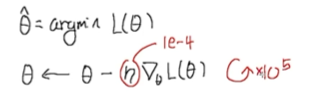

In [2]:
Image("C:\\Users\\ryusu\\OneDrive\\바탕 화면\\2.png")

In [9]:
n_epochs = 100000 #우리는 십만번의 iteration을 돌릴거임
learning_rate = 1e-4
print_interval = 5000

### 딥뉴럴네트워크(DNN) 만들기

## Build Models

### Build Model using nn.Module

In [10]:
relu = nn.ReLU()
leaky_relu = nn.LeakyReLU(0.1)

In [11]:
class MyModel(nn.Module):
    
    def __init__(self, input_dim, output_dim):
        self.input_dim = input_dim
        self.output_dim = output_dim
        
        super().__init__()
        
        #Layer을 3개를 만들거임
        self.linear1 = nn.Linear(input_dim, 3) #input차원입력을 3차원으로 바꿔주고 
        self.linear2 = nn.Linear(3, 3)
        self.linear3 = nn.Linear(3, output_dim)
        self.act = nn.ReLU() #activation function은 학습하는 파라미터가 없기때문에 그냥 함수임. 
                             #그래서 한번만 선언해서 계속 재활용해줄거임 
        
    def forward(self, x):
        # |x| = (batch_size, input_dim) #여기서는 [506 * 13]
        h = self.act(self.linear1(x)) #x를 linear layer 첫번째를 통과시킴. 그럼 [506 * 3]으로 바꿔지고 활성함수 통과시킴
        h = self.act(self.linear2(h)) #그리고 두번째 layer도 또 한번 통과시키면 똑같은 사이즈 결과값이 나온다.
        y = self.linear3(h) #마지막 layer에는 [506,3]이 들어가서 [506,1]이 나와야한다. 중요한거 여기에는 activation function이 없음
        # activation function은 layer 중간에만 넣는거임
        # |y| = (batch_size, output_dim)
        
        return y
    
# 우리는 forward 함수 호출을 통해서 해당 모델에서 우리는 feed-forward 를 할수있는거임
    
#모델 선언
model = MyModel(x.size(-1), y.size(-1))# x.size(-1) = 13, y.size(-1) = 1 
#(('13차원이 입력이고 1차원이 출력이야'라고 하는것을 MyModel함수에 알려줘서 결과값을 모델이라는 변수에 넣는다.))

model

MyModel(
  (linear1): Linear(in_features=13, out_features=3, bias=True)
  (linear2): Linear(in_features=3, out_features=3, bias=True)
  (linear3): Linear(in_features=3, out_features=1, bias=True)
  (act): ReLU()
)

그럼 결과값으로 각 layer에 들어간 입력값과 출력값이 나온다.
act = activation function이라는 뜻

### 더 쉬운 방법 = Build Model with LeakyReLU using nn.Sequential
결과값을 앞 layer들로 보내면 되니깐 이 방법 사용할수있음.

In [12]:
model = nn.Sequential(
    nn.Linear(x.size(-1), 3), # 이 layer출력이 
    nn.LeakyReLU(), # 여기에 들어가고 
    nn.Linear(3, 3), # 위 결과값이 다시 여기에 들어가고 계속 쭉 이어짐.
    nn.LeakyReLU(),
    nn.Linear(3, 3),
    nn.LeakyReLU(),
    nn.Linear(3, 3),
    nn.LeakyReLU(),
    nn.Linear(3, 3),
    nn.LeakyReLU(),
    nn.Linear(3, y.size(-1)),
)
# layer가 6개인 깊은 뉴럴 네트워크를 만듬

model

Sequential(
  (0): Linear(in_features=13, out_features=3, bias=True)
  (1): LeakyReLU(negative_slope=0.01)
  (2): Linear(in_features=3, out_features=3, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=3, out_features=3, bias=True)
  (5): LeakyReLU(negative_slope=0.01)
  (6): Linear(in_features=3, out_features=3, bias=True)
  (7): LeakyReLU(negative_slope=0.01)
  (8): Linear(in_features=3, out_features=3, bias=True)
  (9): LeakyReLU(negative_slope=0.01)
  (10): Linear(in_features=3, out_features=1, bias=True)
)

In [13]:
optimizer = optim.SGD(model.parameters(), #sgd를 통해서 gradient descent수행하는데 대상은 paratmers(W,b)이다.
                      lr=learning_rate)

### SGD
* model을 학습시키기 위해선 optimization라는 작업을 해준다. weight의 torch.backward()라는 함수로, gradient를 구해서 weight의 값을 변화시켜주는 역활을 한다. 가장 기본적인 방법으로

* SGD의 원리
  * 우리가 data를 model에 입력했을 때, model은 그 data의 실제갑과 model의 예측값을 비교하여 loss(오차)를 알려준다. SGD란 loss를 줄이기 위해 고안된 방법으로, loss(오차)의 미분을 이용하여 loss를 줄이는 것이 그 목표이다.
  * 여기서 lr은 Learning Rate의 줄임말이며, 미분값을 얼만큼 이동시킬 것인가를 결정한다. 초기값이 크다면 초반엔 loss값이 빠르게 줄겠지만, 나중에 가면 underfitting이 발생하게 된다.

In [14]:
for i in range(n_epochs):
    y_hat = model(x) #x[506,13]을 넣어주면 [506,1]의 y_hat이 만들어짐
    loss = F.mse_loss(y_hat, y)#y_hat[506,1]와 y[506,1]의 loss(스칼라값)를 구한다. 우리는 loss를 최소화하는 파라미터를 찾는다.
    
    #Loss의 gradient descent를 수행
    optimizer.zero_grad() #gradient descent 초기화
    loss.backward() #backward = 미분(n∇L(θ))
    
    optimizer.step() #미분해서 step 하는게 θ <-- θ - n∇L(θ) 이 과정임. 파라미터 업데이트
    
    if (i + 1) % print_interval == 0:
        print('Epoch %d: loss=%.4e' % (i + 1, loss)) #십만번 반복하는데 loss찍어주는 명령어. 결과보면 loss가 줄어들음

Epoch 5000: loss=8.4416e+01
Epoch 10000: loss=8.4415e+01
Epoch 15000: loss=8.4413e+01
Epoch 20000: loss=7.8406e+01
Epoch 25000: loss=1.3286e+01
Epoch 30000: loss=1.2725e+01
Epoch 35000: loss=1.2526e+01
Epoch 40000: loss=1.1895e+01
Epoch 45000: loss=1.1548e+01
Epoch 50000: loss=1.1223e+01
Epoch 55000: loss=1.0938e+01
Epoch 60000: loss=1.0711e+01
Epoch 65000: loss=9.3744e+00
Epoch 70000: loss=7.6595e+00
Epoch 75000: loss=6.9922e+00
Epoch 80000: loss=7.1098e+00
Epoch 85000: loss=6.8505e+00
Epoch 90000: loss=7.0606e+00
Epoch 95000: loss=6.6112e+00
Epoch 100000: loss=6.5394e+00


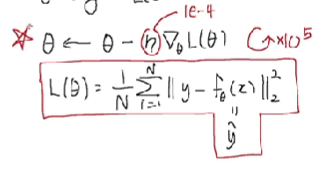

In [4]:
Image("C:\\Users\\ryusu\\OneDrive\\바탕 화면\\3.png")
# 위 수식에서 loss 

## Let's see the result!

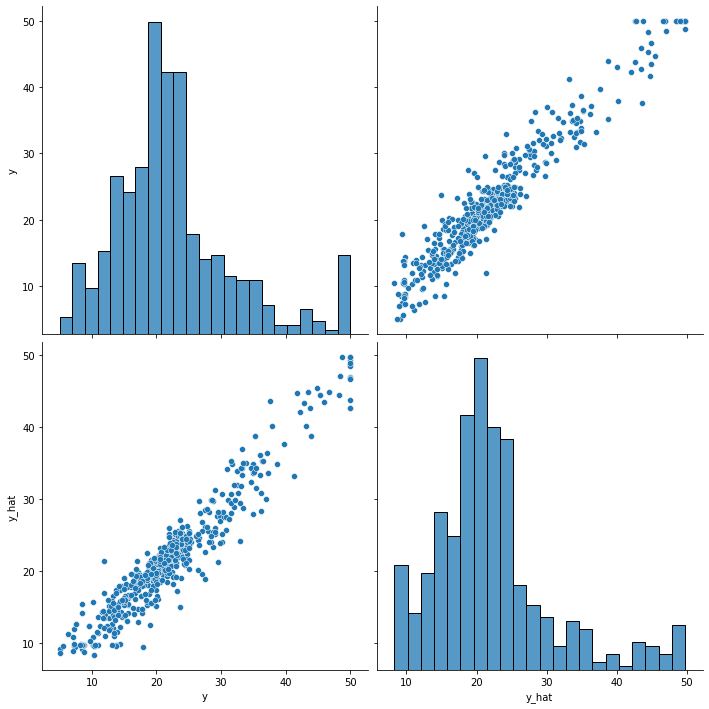

In [15]:
df = pd.DataFrame(torch.cat([y, y_hat], dim=1).detach().numpy(),
                  columns=["y", "y_hat"])

sns.pairplot(df, height=5)
plt.show()